# Pneumonia Classification with Vision Transformer (ViT)

This notebook fine-tunes a Vision Transformer to classify chest X-ray images (NORMAL vs. PNEUMONIA) using the Kaggle dataset.

**What you'll get here**
- A *clean, step-by-step* pipeline mirroring the structure you used for CNN.
- Two ways to load ViT:
  1) **PyTorch native** pretrained models (timm/torchvision).
  2) **Google JAX `.npz`** checkpoints (download + conversion through `timm`).  
- The same *recall-first* threshold tuning you used with the CNN (to prioritize catching sick patients).
- Plots, metrics, and saved artifacts.

> Tip: if you're offline, the notebook will still run — it will just fall back to random init if weights can't be downloaded.


## 0) Setup and dependency checks
Purpose: ensure required libraries are available and detect the best device (CUDA/MPS/CPU).  
- Tries to import `timm`. If missing, attempts a silent `pip install timm`.  
- Sets the `DEVICE`.  
- Prints versions for reproducibility.


In [9]:

# Silent/forgiving install of optional deps (timm) if missing
import sys, subprocess, importlib

def try_import_or_pip(pkg, pip_name=None):
    try:
        return importlib.import_module(pkg)
    except Exception:
        try:
            name = pip_name or pkg
            print(f"Installing {name} ...")
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", name], check=False)
            return importlib.import_module(pkg)
        except Exception as e:
            print(f"Could not import or install {pkg}: {e}")
            return None

timm = try_import_or_pip("timm")

import torch, torchvision, sklearn, numpy as np, matplotlib, matplotlib.pyplot as plt
from pathlib import Path

# Pick best device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)
print("torch:", torch.__version__, "| torchvision:", torchvision.__version__)
print("matplotlib:", matplotlib.__version__, "| sklearn:", sklearn.__version__)
print("timm:", getattr(timm, "__version__", None))


Installing timm ...



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
/Users/fouadaz/LearningFromUniversity/Learning/DeepLearning/DeepLearning_2025/FinalProject/Deep_Learning_Assignments/Final_Project/myfinalproject/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: mps
torch: 2.8.0 | torchvision: 0.23.0
matplotlib: 3.10.5 | sklearn: 1.7.1
timm: 1.0.19


## 1) Dataset location & sanity check
Purpose: locate the Kaggle dataset on disk.  
- Expected structure: `.../chest_xray/{train,val,test}/{NORMAL,PNEUMONIA}`  
- We try common roots (your earlier CNN used `Final_Project/Data/chest_xray`).  
- If not found, we guide you to download with Kaggle CLI, or place the folder manually.


In [10]:

import os, shutil, subprocess
from pathlib import Path

# Try a few common locations; fall back to a default relative path
CANDIDATES = [
    Path.cwd() / "Data" / "chest_xray",
    Path.cwd().parent / "Data" / "chest_xray",
    Path("Final_Project") / "Data" / "chest_xray",
    Path.cwd() / "Final_Project" / "Data" / "chest_xray"
]

DATASET_DIR = None
for c in CANDIDATES:
    if (c / "train").exists() and (c / "val").exists() and (c / "test").exists():
        DATASET_DIR = c
        break

if DATASET_DIR is None:
    DATASET_DIR = Path("Final_Project/Data/chest_xray")  # default
print("Using dataset dir:", DATASET_DIR.resolve())

def has_dataset_structure(root: Path) -> bool:
    return (root / "train").exists() and (root / "val").exists() and (root / "test").exists()

if not has_dataset_structure(DATASET_DIR):
    print("❗Dataset not found at:", DATASET_DIR.resolve())
    print("Please place the Kaggle chest_xray folder at this path, e.g.:")
    print("  Final_Project/Data/chest_xray/{train,val,test}/{NORMAL,PNEUMONIA}")


Using dataset dir: /Users/fouadaz/LearningFromUniversity/Learning/DeepLearning/DeepLearning_2025/FinalProject/Deep_Learning_Assignments/Final_Project/Data/chest_xray


## 2) Data pipeline (grayscale→RGB replication, normalization, loaders)
Purpose: build transforms and DataLoaders.  
- Compute mean/std on a subset of *train* to normalize.  
- ViT expects **3-channel** inputs → replicate grayscale to 3 channels.  
- Use **WeightedRandomSampler** to handle class imbalance.  
- Re-split *train* into `train/val` (you can change the ratio), while keeping *test* untouched.


In [11]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from PIL import Image
import random, numpy as np, torch

IMG_SIZE = 224
BATCH = 32
NUM_WORKERS = 2

def compute_mean_std(root: Path, split: str = "train", max_samples: int = 600):
    files = list((root / split).glob("**/*.*"))
    random.shuffle(files)
    files = files[:max_samples]
    pixels = []
    for f in files:
        try:
            im = Image.open(f).convert("L").resize((IMG_SIZE, IMG_SIZE))
            arr = np.asarray(im, dtype=np.float32) / 255.0
            pixels.append(arr)
        except Exception:
            pass
    if not pixels:
        return 0.5, 0.25
    arr = np.stack(pixels, axis=0)
    return float(arr.mean()), float(arr.std() + 1e-8)

if has_dataset_structure(DATASET_DIR):
    mean, std = compute_mean_std(DATASET_DIR, "train")
    print(f"Norm stats → mean={mean:.4f}, std={std:.4f}")

    # Transforms: replicate grayscale→RGB for ViT
    train_tfms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.08, 0.08), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.12, p=0.25),
        transforms.ToTensor(),
        transforms.Normalize([mean]*3, [std]*3),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3), value="random"),
    ])
    val_test_tfms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([mean]*3, [std]*3),
    ])

    # Load full train, then make a validation split
    full_train_dataset = datasets.ImageFolder(DATASET_DIR / "train", transform=train_tfms)
    val_ratio = 0.2
    val_size = int(len(full_train_dataset) * val_ratio)
    train_size = len(full_train_dataset) - val_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_test_tfms  # make val deterministic

    # Weighted sampling to counter imbalance, 0=NORMAL, 1=PNEUMONIA
    indices = train_dataset.indices if hasattr(train_dataset, "indices") else list(range(len(train_dataset)))
    targets = np.array([full_train_dataset.samples[i][1] for i in indices])
    class_counts = np.bincount(targets, minlength=2)
    class_weights = 1.0 / np.maximum(class_counts, 1)
    sample_weights = class_weights[targets]

    sampler = WeightedRandomSampler(
        weights=torch.as_tensor(sample_weights, dtype=torch.double),
        num_samples=len(sample_weights), replacement=True
    )
    print("Train class counts:", class_counts.tolist())

    # Test set (as provided)
    test_dataset = datasets.ImageFolder(DATASET_DIR / "test", transform=val_test_tfms)

    use_pin = (DEVICE.type == "cuda")
    train_dl = DataLoader(train_dataset, batch_size=BATCH, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=use_pin)
    val_dl   = DataLoader(val_dataset,   batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=use_pin)
    test_dl  = DataLoader(test_dataset,  batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=use_pin)

    print("Classes:", full_train_dataset.class_to_idx)
    print(f"New split → Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
else:
    print("⚠️ Skipping data pipeline because dataset is missing.")


Norm stats → mean=0.4837, std=0.2365
Train class counts: [1070, 3103]
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
New split → Train: 4173 | Val: 1043 | Test: 624


## 3) Metrics, threshold tuning, and plots
Purpose: reusable helpers to evaluate the model and pick a decision threshold.  
- We compute accuracy, precision, recall, F1, AUROC, confusion matrix.  
- We include a **recall-first** tuner: choose the threshold that **maximizes specificity** subject to a minimum *recall* (e.g., ≥ 0.98).  
- Plots: confusion matrix and ROC with operating point.


In [12]:

import os, json, numpy as np, matplotlib.pyplot as plt, torch
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, roc_auc_score,
                             precision_recall_fscore_support, accuracy_score)

def evaluate_on(dl, model, device=DEVICE, threshold=0.5, save_dir=None, criterion=None):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    losses = []
    with torch.no_grad():
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            if criterion is not None:
                loss = criterion(logits, yb)
                losses.append(loss.item())
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = (probs >= threshold).long()

            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy().tolist())

    y_true = np.array(y_true); y_pred = np.array(y_pred); y_scores = np.array(y_scores)
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    auroc = roc_auc_score(y_true, y_scores)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn + 1e-9)
    spec = tn / (tn + fp + 1e-9)
    bal_acc = 0.5 * (sens + spec)

    print(f"Loss={np.mean(losses):.4f}  Acc={acc:.3f}  Prec={p:.3f}  Rec={r:.3f}  F1={f1:.3f}  AUROC={auroc:.3f}")
    print(f" Sensitivity (Recall+): {sens:.3f}")
    print(f" Specificity (TNR   ): {spec:.3f}")
    print(f" Balanced Accuracy  : {bal_acc:.3f}")
    print(f" Threshold used     : {threshold:.2f}")
    print("\nClassification report:\n", classification_report(
        y_true, y_pred, digits=3, target_names=["NORMAL", "PNEUMONIA"]))

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    # Confusion Matrix
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix"); plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["NORMAL", "PNEUMONIA"])
    plt.yticks(tick_marks, ["NORMAL", "PNEUMONIA"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True")
    if save_dir: plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
    plt.show()

    # ROC with operating point
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {auroc:.3f}")
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    _yp = (y_scores >= threshold).astype(int)
    _tn, _fp, _fn, _tp = confusion_matrix(y_true, _yp).ravel()
    fpr_point = _fp / (_fp + _tn + 1e-9)
    tpr_point = _tp / (_tp + _fn + 1e-9)
    plt.scatter([fpr_point], [tpr_point], s=60, marker='o')
    plt.annotate(f"TH={threshold:.2f}", (fpr_point, tpr_point), textcoords="offset points", xytext=(8, -12))
    plt.title("ROC Curve (Test)")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right"); plt.grid(True)
    if save_dir: plt.savefig(os.path.join(save_dir, "roc_curve.png"))
    plt.show()

    return {
        "loss": float(np.mean(losses)), "acc": float(acc), "prec": float(p), "rec": float(r),
        "f1": float(f1), "auroc": float(auroc), "cm": cm, "specificity": float(spec), "sensitivity": float(sens)
    }

def tune_threshold_min_recall(val_dl, model, device=DEVICE, min_rec=0.98):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            probs = torch.softmax(model(xb), dim=1)[:, 1]
            y_true.extend(yb.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy().tolist())
    y_true = np.array(y_true); y_scores = np.array(y_scores)

    def stats(th):
        y_pred = (y_scores >= th).astype(int)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        spec = tn / (tn + fp + 1e-9)
        return p, r, f1, spec

    cands = np.linspace(0.20, 0.90, 71)
    valid = [(th,)+stats(th) for th in cands if stats(th)[1] >= min_rec]
    if not valid:
        print("No threshold meets the min recall constraint; falling back to argmax-F1.")
        all_stats = [(th,)+stats(th) for th in cands]
        best = max(all_stats, key=lambda x: x[3])  # F1 at idx 3
    else:
        # max specificity with recall >= min_rec
        best = max(valid, key=lambda x: x[4])  # spec at idx 4

    th, prec, rec, f1, spec = best
    print(f"Chosen THRESH (val): {th:.2f} | precision={prec:.3f} recall={rec:.3f} f1={f1:.3f} specificity={spec:.3f} (MIN_REC={min_rec})")
    return float(th)


## 4) Build the ViT model
Purpose: create a ViT model one of three ways (in this priority order):
1. **timm** pretrained (AugReg or ImageNet-1k) — recommended if available.  
2. **torchvision** pretrained (ImageNet-1k).  
3. **Google JAX `.npz`** checkpoint → **converted** to PyTorch via `timm`'s filter function.

> If you're offline or a weight download fails, we fall back to random init.


In [13]:

import torch.nn as nn, numpy as np

def try_build_vit_timm(num_classes=2):
    if timm is None:
        return None, "timm_not_available"
    try:
        model = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
        return model, "timm_pretrained"
    except Exception as e:
        print("timm pretrained attempt failed:", e)
        try:
            model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)
            return model, "timm_random"
        except Exception as e2:
            print("timm random attempt failed:", e2)
            return None, "timm_failed"

def try_build_vit_torchvision(num_classes=2):
    try:
        from torchvision.models import vit_b_16, ViT_B_16_Weights
        m = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        m.heads.head = nn.Linear(m.heads.head.in_features, num_classes)
        return m, "torchvision_pretrained"
    except Exception as e:
        print("torchvision pretrained attempt failed:", e)
        try:
            from torchvision.models import vit_b_16
            m = vit_b_16(weights=None)
            m.heads.head = nn.Linear(m.heads.head.in_features, num_classes)
            return m, "torchvision_random"
        except Exception as e2:
            print("torchvision random attempt failed:", e2)
            return None, "torchvision_failed"

def maybe_download_jax_npz(npz_name="ViT-B_16.npz", target_dir=Path("weights/vit_npz")):
    url = f"https://storage.googleapis.com/vit_models/imagenet21k/{npz_name}"
    target_dir.mkdir(parents=True, exist_ok=True)
    out = target_dir / npz_name
    if out.exists():
        print("Found npz:", out)
        return out
    try:
        import urllib.request
        print("Downloading:", url)
        urllib.request.urlretrieve(url, out)
        print("Saved:", out)
        return out
    except Exception as e:
        print("Couldn't download npz:", e)
        return None

def try_build_vit_from_jax_npz(num_classes=2, npz_path=None):
    if timm is None:
        print("timm not available → cannot convert .npz")
        return None, "jax_npz_failed"
    if npz_path is None or not Path(npz_path).exists():
        npz_path = maybe_download_jax_npz()
        if npz_path is None:
            return None, "jax_npz_download_failed"
    try:
        from timm.models.vision_transformer import checkpoint_filter_fn
        model = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)
        dd = np.load(npz_path)
        # Convert numpy to tensors and map keys via timm's filter
        sd_raw = {k: torch.from_numpy(v) for k, v in dd.items()}
        sd = checkpoint_filter_fn(sd_raw, model)
        missing, unexpected = model.load_state_dict(sd, strict=False)
        print("Loaded JAX npz → PyTorch. Missing keys:", len(missing), "| Unexpected:", len(unexpected))
        return model, "jax_npz_converted"
    except Exception as e:
        print("JAX npz conversion failed:", e)
        return None, "jax_npz_failed"

# Try to build in priority order
model, how = try_build_vit_timm(num_classes=2)
if model is None:
    model, how = try_build_vit_torchvision(num_classes=2)
if model is None:
    model, how = try_build_vit_from_jax_npz(num_classes=2)

if model is None:
    raise RuntimeError("Could not build a ViT model by any method.")
model = model.to(DEVICE)
print("Model ready via:", how)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)


timm pretrained attempt failed: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/vit_base_patch16_224.augreg2_in21k_ft_in1k/resolve/main/model.safetensors (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)')))"), '(Request ID: 14a695b0-6399-4d96-b1f4-7e9a19a341f8)')
Model ready via: timm_random
Params (M): 85.800194


## 5) Training loop (head-only warmup → fine-tune all)
Purpose: train ViT in two phases (like your ResNet18 baseline did):  
1. **Head-only warmup**: freeze backbone and train the classifier head briefly.  
2. **Fine-tune**: unfreeze everything, lower LR, train with early stopping.

We use **class-weighted cross-entropy** to mitigate imbalance, and a `ReduceLROnPlateau` scheduler.


In [14]:

import time, torch.optim as optim, torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Class weights from the actual TRAIN split
if has_dataset_structure(DATASET_DIR):
    indices = train_dataset.indices if hasattr(train_dataset, "indices") else list(range(len(train_dataset)))
    targets = np.array([full_train_dataset.samples[i][1] for i in indices])
    class_counts = np.bincount(targets, minlength=2)
else:
    class_counts = np.array([1,1])

normal_count, pneu_count = int(class_counts[0]), int(class_counts[1])
total = max(1, normal_count + pneu_count)
weights = torch.tensor([pneu_count/total, normal_count/total], device=DEVICE, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)
print("Class weights in loss:", [float(w) for w in weights])

def run_epoch(dl, model, optimizer=None, device=DEVICE):
    is_train = optimizer is not None
    model.train(is_train)
    losses, y_true, y_pred, y_scores = [], [], [], []
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
        losses.append(loss.item())

        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = (probs >= 0.5).long()
        y_scores.extend(probs.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())
        y_true.extend(yb.detach().cpu().numpy().tolist())

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_scores)
    except Exception:
        auc = None
    return float(np.mean(losses)), acc, p, r, f1, auc

def train_head_then_finetune(model, train_dl, val_dl, head_epochs=2, ft_epochs=8, lr_head=1e-3, lr_ft=1e-4, weight_decay=1e-4):
    # 1) Head-only
    for p in model.parameters(): p.requires_grad = False
    head_params = []
    if hasattr(model, "heads") and hasattr(model.heads, "head"):
        head_params = list(model.heads.head.parameters())
    elif hasattr(model, "head"):
        head_params = list(model.head.parameters())
    else:
        head_params = [p for p in model.parameters() if p.requires_grad]

    for p in head_params: p.requires_grad = True
    opt = optim.AdamW(head_params, lr=lr_head, weight_decay=weight_decay)

    best_val = float('inf')
    for e in range(head_epochs):
        tr = run_epoch(train_dl, model, optimizer=opt)
        va = run_epoch(val_dl,   model, optimizer=None)
        print(f"[Head] {e+1}/{head_epochs}  train_loss={tr[0]:.4f}  val_loss={va[0]:.4f}  val_f1={va[4]:.3f}  auc={va[5]}")
        if va[0] < best_val:
            best_val = va[0]; torch.save(model.state_dict(), "vit_head.pt")

    # 2) Fine-tune all
    model.load_state_dict(torch.load("vit_head.pt", map_location=DEVICE))
    for p in model.parameters(): p.requires_grad = True
    opt = optim.AdamW(model.parameters(), lr=lr_ft, weight_decay=weight_decay)
    sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2)

    for e in range(ft_epochs):
        tr = run_epoch(train_dl, model, optimizer=opt)
        va = run_epoch(val_dl,   model, optimizer=None)
        print(f"[FT]   {e+1}/{ft_epochs}  train_loss={tr[0]:.4f}  val_loss={va[0]:.4f}  val_f1={va[4]:.3f}  auc={va[5]}")
        sched.step(va[0])
        if va[0] < best_val:
            best_val = va[0]; torch.save(model.state_dict(), "vit_best.pt")
    return model

if has_dataset_structure(DATASET_DIR):
    model = train_head_then_finetune(model, train_dl, val_dl, head_epochs=2, ft_epochs=8, lr_head=1e-3, lr_ft=1e-4, weight_decay=1e-4)
    model.load_state_dict(torch.load("vit_best.pt", map_location=DEVICE))
    print("Best checkpoint loaded.")
else:
    print("⚠️ Skipping training because dataset is missing.")


Class weights in loss: [0.7435897588729858, 0.25641027092933655]
[Head] 1/2  train_loss=0.4595  val_loss=0.5992  val_f1=0.601  auc=0.8409221268378486
[Head] 2/2  train_loss=0.3927  val_loss=0.5092  val_f1=0.718  auc=0.879113052788559
[FT]   1/8  train_loss=0.7200  val_loss=1.4451  val_f1=0.346  auc=0.9086429076725999
[FT]   2/8  train_loss=0.2999  val_loss=0.3294  val_f1=0.925  auc=0.9494579660822515
[FT]   3/8  train_loss=0.2398  val_loss=0.3459  val_f1=0.843  auc=0.9708716517216986
[FT]   4/8  train_loss=0.2005  val_loss=0.2380  val_f1=0.949  auc=0.9734862244995507
[FT]   5/8  train_loss=0.1717  val_loss=0.2595  val_f1=0.891  auc=0.9781035504655564
[FT]   6/8  train_loss=0.1100  val_loss=0.2168  val_f1=0.934  auc=0.9817935873659254
[FT]   7/8  train_loss=0.1119  val_loss=0.2590  val_f1=0.888  auc=0.98597594784238
[FT]   8/8  train_loss=0.1035  val_loss=0.1993  val_f1=0.943  auc=0.9839731946542264
Best checkpoint loaded.


## 6) Pick an operating threshold with a **minimum recall** constraint
Purpose: be **aggressive in catching sick patients** (high sensitivity/recall) while improving specificity as much as possible.
- We search thresholds and choose the one with **max specificity** subject to `recall ≥ MIN_REC`.


In [15]:

THRESH = 0.5
if has_dataset_structure(DATASET_DIR):
    MIN_REC = 0.975  # adjust as policy requires
    THRESH = tune_threshold_min_recall(val_dl, model, device=DEVICE, min_rec=MIN_REC)
    print(f"Final THRESH set to {THRESH:.2f}")
else:
    print("Dataset missing → keep default THRESH=0.5")


No threshold meets the min recall constraint; falling back to argmax-F1.
Chosen THRESH (val): 0.20 | precision=0.984 recall=0.934 f1=0.958 specificity=0.956 (MIN_REC=0.975)
Final THRESH set to 0.20


## 7) Final evaluation on the untouched test set
Purpose: report your final metrics **only on the test set** (confusion matrix, ROC, JSON dump).  
We save figures and metrics under `results_vit/`.


Loss=0.6545  Acc=0.821  Prec=0.800  Rec=0.951  F1=0.869  AUROC=0.918
 Sensitivity (Recall+): 0.951
 Specificity (TNR   ): 0.603
 Balanced Accuracy  : 0.777
 Threshold used     : 0.20

Classification report:
               precision    recall  f1-score   support

      NORMAL      0.881     0.603     0.716       234
   PNEUMONIA      0.800     0.951     0.869       390

    accuracy                          0.821       624
   macro avg      0.840     0.777     0.792       624
weighted avg      0.830     0.821     0.811       624



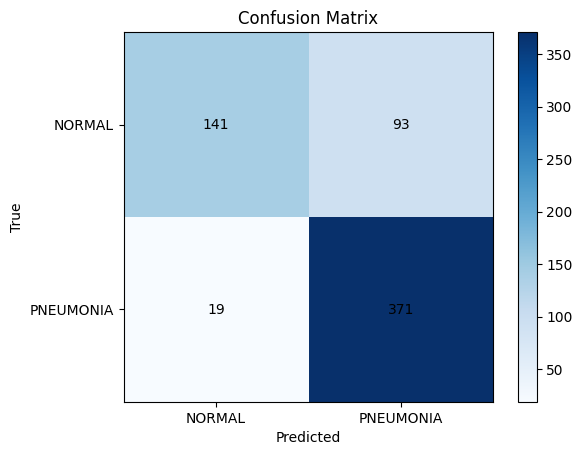

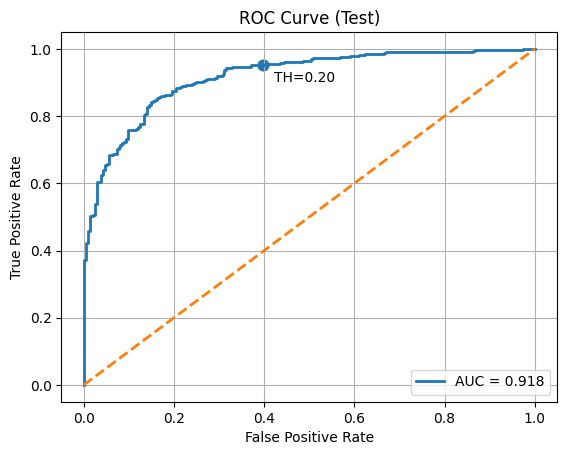

In [16]:

import os
SAVE_DIR = "results_vit"
if has_dataset_structure(DATASET_DIR):
    os.makedirs(SAVE_DIR, exist_ok=True)
    _ = evaluate_on(test_dl, model, device=DEVICE, threshold=THRESH, save_dir=SAVE_DIR, criterion=criterion)
else:
    print("Dataset missing → skipping test evaluation.")


## 8) Model complexity snapshot
Purpose: quantify model size and (optionally) estimate throughput.


In [17]:

param_count = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Parameters total: {param_count:,}  |  trainable now: {trainable:,}")

# Optional quick speed probe (few batches)
if has_dataset_structure(DATASET_DIR):
    import time
    model.eval()
    n_batches = 10
    t0 = time.time()
    with torch.no_grad():
        for i, (xb, _) in enumerate(train_dl):
            if i >= n_batches: break
            xb = xb.to(DEVICE)
            _ = model(xb)
    dt = time.time() - t0
    print(f"Inference over {n_batches} mini-batches took {dt:.2f}s  (~{(n_batches*BATCH)/max(dt,1e-9):.1f} img/s).")


Parameters total: 85,800,194  |  trainable now: 85,800,194
Inference over 10 mini-batches took 19.14s  (~16.7 img/s).


## 9) (Optional) Download official Google JAX `.npz` checkpoint
Purpose: stash the **exact** ViT-B/16 ImageNet-21k checkpoint locally.  
You can later try the conversion cell in Section 4 to load it into PyTorch (`timm` required).


In [18]:

from pathlib import Path, PurePosixPath
npz_path = maybe_download_jax_npz("ViT-B_16.npz")
print("npz path:", npz_path)


Downloading: https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz
Saved: weights/vit_npz/ViT-B_16.npz
npz path: weights/vit_npz/ViT-B_16.npz
